In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from geodatasets import get_path
import numpy as np
import xarray as xr

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_22713/3136705849.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Mankoff

In [4]:
path_Mankoff2020Solid = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/freshwaterII/data/raw/solid_discharge/Mankoff2020Solid/"
dfRegionDMankoff = pd.read_csv(path_Mankoff2020Solid + "region_D.csv", index_col=0)
dfErrorRegionDMankoff = pd.read_csv(path_Mankoff2020Solid + "region_err.csv", index_col=0)
dfRegionDMankoff.index = pd.to_datetime(dfRegionDMankoff.index)
dfRegionCovManoff = pd.read_csv(path_Mankoff2020Solid + "region_coverage.csv", index_col=0)
filterCovReg =  (dfRegionCovManoff < 0.5).values


dfGISDMankoff = pd.read_csv(path_Mankoff2020Solid + "GIS_D.csv", index_col=0, parse_dates=True)
dfErrorGISDMankoff = pd.read_csv(path_Mankoff2020Solid + "GIS_err.csv", index_col=0, parse_dates=True)
dfGIScoverageMankoff = pd.read_csv(path_Mankoff2020Solid + "GIS_coverage.csv", index_col=0, parse_dates=True)
filterCov =  (dfGIScoverageMankoff < 0.5).values

dsGate = xr.open_dataset(path_Mankoff2020Solid + "gate.nc")



Kochtitzky

In [5]:
path_frontal_ablation_per_glacier = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/freshwaterII/data/raw/solid_discharge/Kochtitzky2023/CCIN13272_20220623_Greenland_frontal_ablation_by_glacier_Kochtitzky_et_al_v2.csv"

dtypesFloat = ['2000_2010_mean_velocity',
       '2000_2010_mean_velocity_error', '2010_2020_mean_velocity',
       '2010_2020_mean_velocity_error', 'best_thickness_early',
       'best_thickness_early_err', 'best_thickness_late',
       'best_thickness_late_err', 
       'FA_not_calculated_in_normal_way_early',
       'FA_not_calculated_in_normal_way_late',
       'net_area_change_km2_per_year_early',
       'net_area_change_km2_per_year_early_error',
       'net_area_change_km2_per_year_late',
       'net_area_change_km2_per_year_late_error',
       'melt_correct_gt_early_terminus_change',
       'melt_correct_gt_early_err_terminus_change',
       'melt_correct_gt_late_terminus_change',
       'melt_correct_gt_late_err_terminus_change',
       'melt_correct_gt_early_discharge',
       'melt_correct_gt_early_err_discharge',
       'melt_correct_gt_late_discharge',
       'melt_correct_gt_late_err_discharge',
       'terminus_gt_change_per_year_early',
       'terminus_gt_change_per_year_early_area_error',
       'terminus_gt_change_per_year_late',
       'terminus_gt_change_per_year_late_area_error',
       '2000_2010_mean_discharge_gt_per_year',
       '2000_2010_mean_flux_err_gt',
       '2010_2020_mean_discharge_gt_per_year',
       '2010_2020_mean_flux_err_gt',
       'Frontal_ablation_2000_to_2010_gt_per_yr_mean',
       'Frontal_ablation_2000_to_2010_gt_per_yr_mean_err',
       'Frontal_ablation_2010_to_2020_gt_per_yr_mean',
       'Frontal_ablation_2010_to_2020_gt_per_yr_mean_err', ]

dfKoch = pd.read_csv(path_frontal_ablation_per_glacier, sep =',', encoding='ISO-8859-1', header=13)
dictKoch =dfKoch.iloc[0].to_dict()
dfKoch = dfKoch.iloc[1:]
dfKoch[dtypesFloat] = dfKoch[dtypesFloat].astype(float)
dfKoch['geometry'] = dfKoch['geometry'].apply(wkt.loads)
dfKoch['Name'] = dfKoch['Name'].astype(str)
dfKoch['geometry_glaciers'] = dfKoch['geometry']
gdfKoch = gpd.GeoDataFrame(dfKoch, crs='epsg:3995')
gdfKoch = gpd.GeoDataFrame(dfKoch, geometry=gpd.points_from_xy(dfKoch.lon, dfKoch.lat), crs='epsg:4326')

In [6]:
def isolated_nans(df):
    """
    Find isolated NaN values in a DataFrame and return a boolean mask of the same shape.
    """
    # Create shifted versions of the DataFrame
    df_shifted_up = df.shift(-1)
    df_shifted_down = df.shift(1)

    # Find values that are surrounded by NaN values
    surrounded_by_nan = df.notna() & df_shifted_up.isna() & df_shifted_down.isna()
    return surrounded_by_nan.values



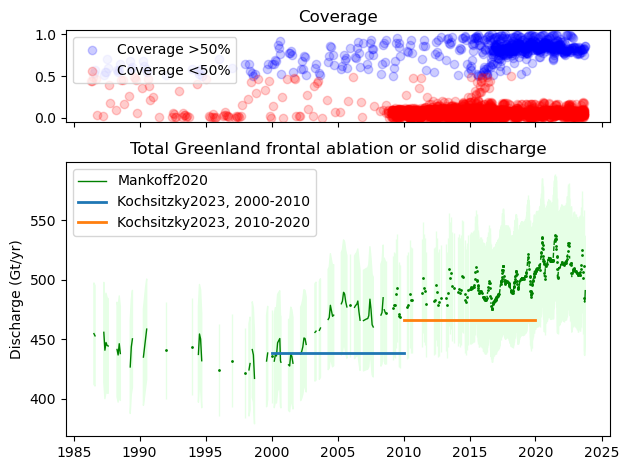

In [7]:
fig, (axCov, ax,) = plt.subplots(2,1, sharex=True, height_ratios=[1,3])

light_opaque_green= (0.9, 1, 0.9, 1)  # RGBA color
ax.fill_between(dfGISDMankoff.mask(filterCov).index, (dfGISDMankoff - dfErrorGISDMankoff.values).mask(filterCov).squeeze().to_numpy(),(dfGISDMankoff + dfErrorGISDMankoff.values).mask(filterCov).squeeze().to_numpy(), color=light_opaque_green)
ax.plot(dfGISDMankoff.mask(filterCov).index, dfGISDMankoff.mask(filterCov), color='green', label='Mankoff2020', linewidth =1 )
ax.scatter(dfGISDMankoff[isolated_nans(dfGISDMankoff.mask(filterCov))].index, dfGISDMankoff[isolated_nans(dfGISDMankoff.mask(filterCov))], color='green', s = 1)

ax.plot(pd.to_datetime(["2000", "2010"]), np.repeat(dfKoch['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].sum(),2),  label='Kochsitzky2023, 2000-2010', linewidth=2)
ax.plot(pd.to_datetime(["2010", "2020"]), np.repeat(dfKoch['Frontal_ablation_2010_to_2020_gt_per_yr_mean'].sum(),2),  label='Kochsitzky2023, 2010-2020', linewidth=2)

plt.legend()
ax.set_ylabel('Discharge (Gt/yr)')
ax.set_title('Total Greenland frontal ablation or solid discharge')

axCov.scatter(dfGIScoverageMankoff.mask(filterCov).index, dfGIScoverageMankoff.mask(filterCov), label='Coverage >50%', color='blue',alpha=0.2)
axCov.scatter(dfGIScoverageMankoff.mask(~filterCov).index, dfGIScoverageMankoff.mask(~ filterCov), label='Coverage <50%', color='red',alpha=0.2)

axCov.set_title('Coverage')
axCov.legend()
plt.tight_layout()

In [8]:
random.shuffle(colors)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmcrameri.cm as ccm
import random

# Define the number of colors you want
n_colors = 7

# Create a color array from the 'crameri' colormap
colors = ccm.batlowS(np.linspace(0, 1, n_colors))


# Create a discrete colormap from the color array
discrete_cmap_regions = mcolors.ListedColormap(colors)

# Now you can use 'discrete_cmap' as a colormap in your plots

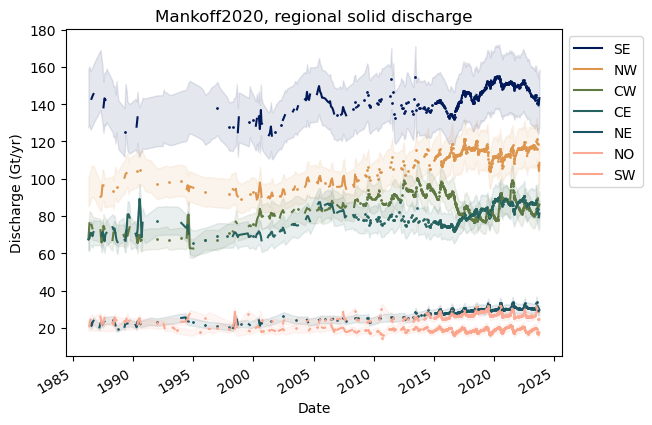

In [10]:

region_by_discharge = dfRegionDMankoff['2010':'2020'].mean().sort_values(ascending=False).index.to_numpy()
def invert_legend_order(ax):
    '''Inverts legend order
    Input = ax
    '''
    # Get the handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # Reverse the handles and labels
    handles, labels = handles[::-1], labels[::-1]
    # Create the legend with the reversed handles and labels
    ax.legend(handles, labels)
    return  handles, labels

fig, ax = plt.subplots()

for i,region in enumerate(region_by_discharge):
    ax.fill_between(dfRegionDMankoff.index, dfRegionDMankoff[region] - dfErrorRegionDMankoff[region].values, dfRegionDMankoff[region] + dfErrorRegionDMankoff[region].values, alpha=0.1, color=colors[i])
    isolated_obs = dfRegionDMankoff[region][isolated_nans(dfRegionDMankoff.mask(filterCovReg)[region])]
    ax.scatter(isolated_obs.index, isolated_obs, s=1, color=colors[i])
dfRegionDMankoff.mask(filterCovReg)[region_by_discharge].plot(ax=ax, colormap=discrete_cmap_regions, legend=False)



plt.title('Mankoff2020, regional solid discharge')
plt.ylabel('Discharge (Gt/yr)')
# legend, plot inverse
# Get the current axes
ax = plt.gca()
handles,labels =  invert_legend_order(ax)
# put legend in bottom right
plt.legend( loc='upper left', bbox_to_anchor=(1, 1))





In [42]:
dfErrorRegionDMankoff.shape

(2799, 7)

In [43]:
dfRegionDMankoff.shape

(2799, 7)

# Per Gate 

In [85]:
dsGate

<xarray.Dataset>
Dimensions:        (time: 2799, gate: 267)
Coordinates:
  * time           (time) datetime64[ns] 1986-04-15 1986-05-15 ... 2023-10-09
  * gate           (gate) int64 1 3 4 5 6 7 8 10 ... 350 352 353 354 355 356 357
Data variables: (12/14)
    discharge      (gate, time) float32 ...
    err            (gate, time) float32 ...
    coverage       (gate, time) float32 ...
    mean_x         (gate) int32 ...
    mean_y         (gate) int32 ...
    mean_lon       (gate) float32 ...
    ...             ...
    region         (gate) <U2 ...
    Zwally_2012    (gate) int64 ...
    name_Bjørk     (gate) <U39 ...
    name_Mouginot  (gate) <U32 ...
    ID_Moon        (gate) int64 ...
    ID_Moon_dist   (gate) int64 ...
Attributes:
    featureType:      timeSeries
    title:            Greenland discharge
    summary:          Greenland discharge per gate
    keywords:         Greenland; Ice Discharge; Calving; Submarine Melt
    source:           git commit: 840f081
    creator_name:     Ken Mankoff
    creator_email:    kdm@geus.dk
    creator_url:      http://kenmankoff.com
    institution:      GEUS
    references:       10.22008/promice/ice_discharge
    product_version:  2.0

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_59086/2754700883.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

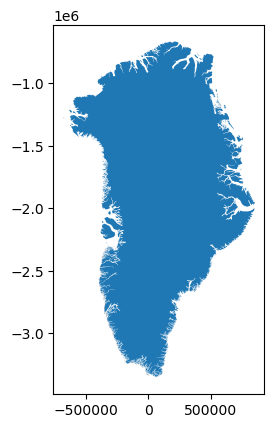

In [112]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the world countries dataset included in geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select Greenland
greenland = world[world['name'] == 'Greenland']

# Plot the boundary of Greenland
greenland.boundary.plot(ax=ax, color='black')
plt.show()

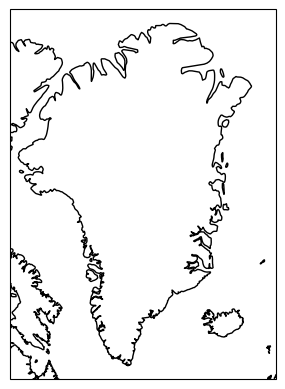

In [123]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a new figure
fig = plt.figure()

# Add a new axes to the figure with a Mercator projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Add coastlines to the map
ax.coastlines()
ax.set_extent([-75, -5, 58, 88])

# Show the map
plt.show()


/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_59086/2884140233.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=colorD(examples[0]),  s=examples[0]*10, label=f'{examples[0]*1000:.0f} Mt/yr')
/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_59086/2884140233.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=colorD(examples[1]), s=examples[1]*10, label=f'{e

Text(0.5, 1.0, 'Mankoff 2010-2020 mean discharge')

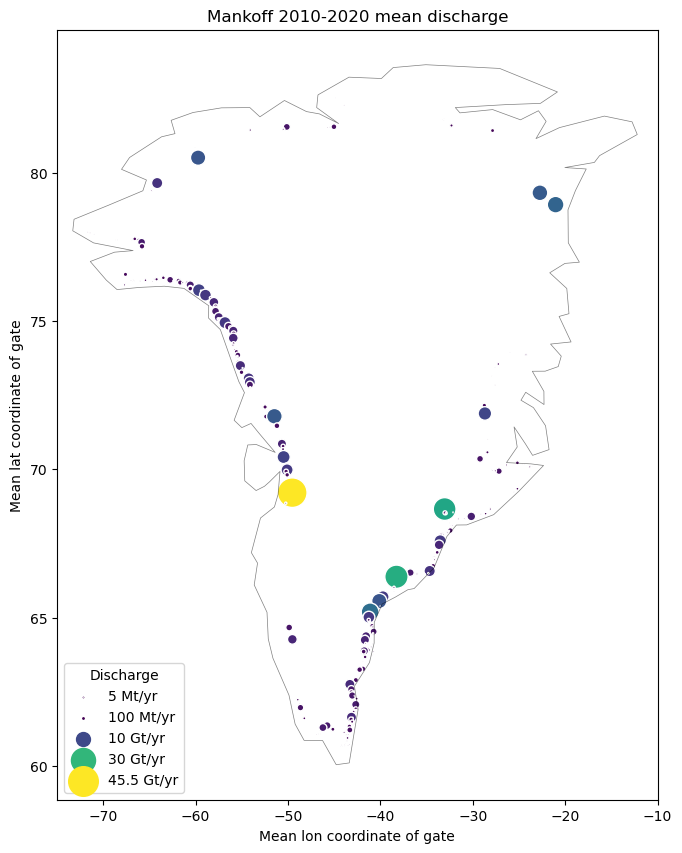

In [191]:
dsGate 
# add coordinate mean_lon and mean_lat 
mean_d = dsGate['discharge'].sel(time=slice('2010', '2020')).mean(dim='time').values
fig, (axM, asK)= plt.subplots(2,1figsize=(20, 10))

greenland.boundary.plot(ax=ax, color='black', alpha = 0.5, linewidth=0.5)

dsGate.assign_coords({'mean_lon': dsGate.mean_lon, 'mean_lat': dsGate.mean_lat}).mean(dim='time').plot.scatter(x='mean_lon', y='mean_lat', c=mean_d, s=mean_d*10, cmap='viridis')

examples = dsGate['discharge'].sel(time=slice('2010', '2020')).mean(dim='time').quantile([0,0.25, 0.5, 0.75, 1]).values
examples = [min(mean_d), 1e-1, 10, 30, max(mean_d)]
# convert mean_d to color in 'viridis'
def colorD(discharge, maximum_discharge=mean_d.max()):
    return plt.cm.viridis(discharge/ maximum_discharge)


ax.scatter([], [], c=colorD(examples[0]),  s=examples[0]*10, label=f'{examples[0]*1000:.0f} Mt/yr')
ax.scatter([], [], c=colorD(examples[1]), s=examples[1]*10, label=f'{examples[1]*1000:.0f} Mt/yr')
ax.scatter([], [], c=colorD(examples[2]), s=examples[2]*10, label=f'{examples[2]:.0f} Gt/yr')
ax.scatter([], [], c=colorD(examples[3]), s=examples[3]*10, label=f'{examples[3]:.0f} Gt/yr')
ax.scatter([], [], c=colorD(examples[4]), s=examples[4]*10, label=f'{examples[4]:.1f} Gt/yr')
ax.legend(title='Discharge', loc='lower left')
ax.set_xlim(-75, -10)

ax.set_title('Mankoff 2010-2020 mean discharge')


In [208]:
dfGateMankoff = dsGate.sel(time=slice('2010', '2020')).mean(dim='time').to_dataframe().reset_index()

,gate,discharge,err,coverage,mean_x,mean_y,mean_lon,mean_lat,sector,region,Zwally_2012,name_Bjørk,ID_Moon,ID_Moon_dist
name_Mouginot,,,,,,,,,,,,,,
JUNGERSEN_HENSON_NARAVANA,1,0.092048,0.025356,0.075844,600,-812300,-44.951626,82.517509,77,NO,13,Jungersen Gletsjer,101,45395
JUNGERSEN_HENSON_NARAVANA,3,0.028989,0.006583,0.111578,15700,-838380,-43.927139,82.277077,77,NO,13,Jungersen Gletsjer,100,25459
MARIE_SOPHIE_GLETSCHER,4,0.125793,0.022752,0.121465,182566,-871500,-33.163994,81.799423,55,NO,13,Marie Sophie Gletsjer,103,4007
HAGEN_BRAE,5,0.890318,0.108110,0.161701,274094,-889973,-27.868307,81.424919,216,NO,13,Hagen Br,105,2815
BRIKKERNE_GLETSCHER,6,0.077927,0.068260,0.048203,-3633,-888366,-45.239799,81.818748,215,NO,12,Harder Gletsjer,99,4720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOUTHERN_TIP,353,0.036034,0.008338,0.031542,92500,-3238500,-43.364101,60.718678,111,SE,50,Sermeq,235,21458
SOUTHERN_TIP,354,0.007865,0.003236,0.053925,62700,-3238300,-43.890980,60.726597,111,SE,50,Sermeq,238,4893
SOUTHERN_TIP,355,0.055184,0.026264,0.084780,64625,-3243200,-43.857368,60.682934,111,SE,50,Sermeq,238,5438


In [314]:
# sum if same name_Mouginot
dfGateMankoffgrouped = dfGateMankoff.groupby('name_Mouginot').sum().reset_index()
dfGateMankoffmean = dfGateMankoff.groupby('name_Mouginot').mean(numeric_only=True).reset_index()
cols = ['err', 'coverage', 'mean_x',  'mean_y', 'mean_lon', 'mean_lat']
dfGateMankoffgrouped[cols] = dfGateMankoffmean[cols]

dfDisMerge = pd.merge(dfGateMankoffgrouped, dfKoch, left_on='name_Mouginot', right_on='Name')
dfDisMerge['Mankoff-Koch'] = dfDisMerge['discharge'] - dfDisMerge['Frontal_ablation_2010_to_2020_gt_per_yr_mean']
dfDisMerge['Mankoff-Koch'].describe()

import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap_diff = cm.get_cmap('RdBu_r', 256)
norm_diff = mcolors.TwoSlopeNorm(vmin=-14, vcenter=0, vmax=6)



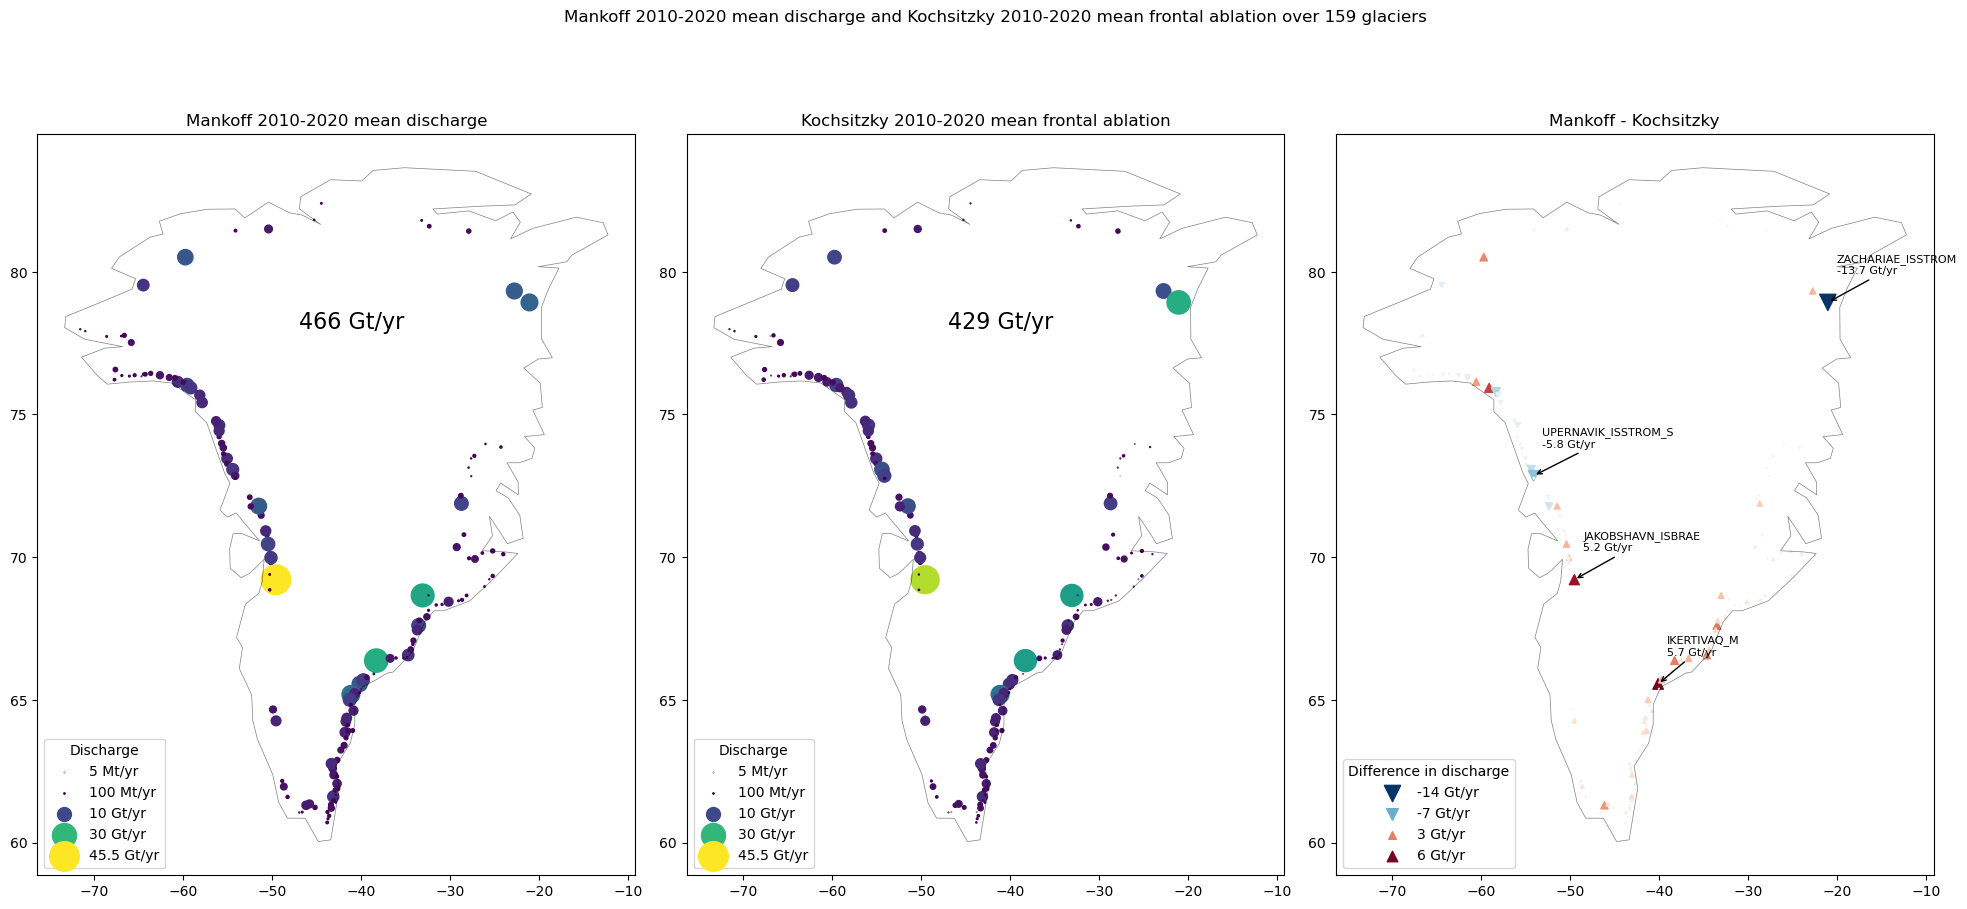

In [332]:
import warnings 
warnings.filterwarnings('ignore')
fig, (axM, axK, axDIFF)= plt.subplots(1,3, figsize=(20, 10))
titles = ['Mankoff 2010-2020 mean discharge', 'Kochsitzky 2010-2020 mean frontal ablation', 'Mankoff - Kochsitzky']

# convert mean_d to color in 'viridis'
def colorD(discharge, maximum_discharge=mean_d.max()):
    return plt.cm.viridis(discharge/ maximum_discharge)

for ax in [axM, axK, axDIFF]: 
    greenland.boundary.plot(ax=ax, color='black', alpha = 0.5, linewidth=0.5)
    ax.set_title(titles.pop(0))
dfDisMerge['mean_lon'] 
axM.scatter(dfDisMerge['mean_lon'], dfDisMerge['mean_lat'], c=colorD(dfDisMerge['discharge']), s=dfDisMerge['discharge']*10, cmap='viridis')
axK.scatter(dfDisMerge['mean_lon'], dfDisMerge['mean_lat'], c=colorD(dfDisMerge['Frontal_ablation_2010_to_2020_gt_per_yr_mean']), s=dfDisMerge['Frontal_ablation_2010_to_2020_gt_per_yr_mean']*10, cmap='viridis')
axDIFF.scatter(dfDisMerge['mean_lon'][dfDisMerge['Mankoff-Koch']>0], dfDisMerge['mean_lat'][dfDisMerge['Mankoff-Koch']>0], c=dfDisMerge['Mankoff-Koch'][dfDisMerge['Mankoff-Koch']>0], s=10*dfDisMerge['Mankoff-Koch'][dfDisMerge['Mankoff-Koch']>0].abs(), cmap=cmap_diff, norm=norm_diff, marker='^')
axDIFF.scatter(dfDisMerge['mean_lon'][dfDisMerge['Mankoff-Koch']<0], dfDisMerge['mean_lat'][dfDisMerge['Mankoff-Koch']<0], c=dfDisMerge['Mankoff-Koch'][dfDisMerge['Mankoff-Koch']<0], s=10*dfDisMerge['Mankoff-Koch'][dfDisMerge['Mankoff-Koch']<0].abs(), cmap=cmap_diff, norm=norm_diff, marker='v')

# ANNONTATE
axM.text(-47, 78, f'{dfDisMerge["discharge"].sum():.0f} Gt/yr', fontsize=16)
axK.text(-47, 78, f'{dfDisMerge["Frontal_ablation_2010_to_2020_gt_per_yr_mean"].sum():.0f} Gt/yr', fontsize=16)
minindex = dfDisMerge['Mankoff-Koch'].idxmin()
maxindex = dfDisMerge['Mankoff-Koch'].idxmax()
secondminindex = dfDisMerge['Mankoff-Koch'].drop(minindex).idxmin()
secondmaxindex = dfDisMerge['Mankoff-Koch'].drop(maxindex).idxmax()
for idx in [minindex, maxindex, secondminindex, secondmaxindex]:
    axDIFF.annotate(f"{dfDisMerge['name_Mouginot'][idx]}\n{dfDisMerge['Mankoff-Koch'][idx]:.1f} Gt/yr", (dfDisMerge['mean_lon'][idx], dfDisMerge['mean_lat'][idx]), fontsize=8, xytext=(dfDisMerge['mean_lon'][idx]+1, dfDisMerge['mean_lat'][idx]+1), arrowprops=dict(facecolor='black', arrowstyle='->'))


examples = dsGate['discharge'].sel(time=slice('2010', '2020')).mean(dim='time').quantile([0,0.25, 0.5, 0.75, 1]).values
examples = [min(mean_d), 1e-1, 10, 30, max(mean_d)]

for ax in [axM, axK]:
    ax.scatter([], [], c=colorD(examples[0]),  s=examples[0]*10, label=f'{examples[0]*1000:.0f} Mt/yr')
    ax.scatter([], [], c=colorD(examples[1]), s=examples[1]*10, label=f'{examples[1]*1000:.0f} Mt/yr')
    ax.scatter([], [], c=colorD(examples[2]), s=examples[2]*10, label=f'{examples[2]:.0f} Gt/yr')
    ax.scatter([], [], c=colorD(examples[3]), s=examples[3]*10, label=f'{examples[3]:.0f} Gt/yr')
    ax.scatter([], [], c=colorD(examples[4]), s=examples[4]*10, label=f'{examples[4]:.1f} Gt/yr')
    ax.legend(title='Discharge', loc='lower left')


# find color corresponding to examples_diff using cmap_diff and norm_diff

examples_diff = [dfDisMerge['Mankoff-Koch'].min(), -7, 3, dfDisMerge['Mankoff-Koch'].max()]
colorDIFF = cmap_diff(norm_diff(examples_diff))
markerDIFF = ['v','v','^','^']
for i in range(len(examples_diff)):
    axDIFF.scatter([], [], c=colorDIFF[i], cmap =cmap_diff,  s=np.abs(examples_diff[i]*10), label=f'{examples_diff[i]:.0f} Gt/yr', marker=markerDIFF[i])
axDIFF.legend(title='Difference in discharge', loc='lower left')


# give suptitle
plt.suptitle('Mankoff 2010-2020 mean discharge and Kochsitzky 2010-2020 mean frontal ablation over {} glaciers'.format(len(dfDisMerge)))
plt.tight_layout()


In [313]:
dfGateMankoff
# sum if same name_Mouginot
dfGateMankoffgrouped = dfGateMankoff.groupby('name_Mouginot').sum().reset_index()
dfGateMankoffmean = dfGateMankoff.groupby('name_Mouginot').mean(numeric_only=True).reset_index()
cols = ['err', 'coverage', 'mean_x',  'mean_y', 'mean_lon', 'mean_lat']
dfGateMankoffgrouped[cols] = dfGateMankoffmean[cols]